## 糖尿病數據集

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
#輸入資料
diadata = pd.read_csv('./diabetes.csv')  
diadata.head(10) 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [3]:
#計算有糖尿病與沒有糖尿病的人數，並檢查是否有輸入錯誤的資料
Count = diadata.groupby(["Outcome"], as_index=False)["Outcome"].agg({"cnt": "count"})
print(Count)

   Outcome  cnt
0        0  500
1        1  268


* 檢查數值特徵分佈

Text(0.5, 1.0, 'Outcome')

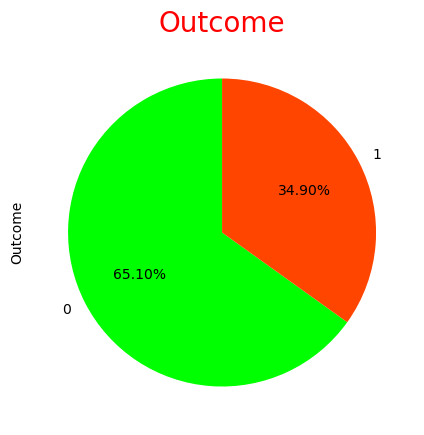

In [4]:
colors = ["lime", "orangered"]
diadata["Outcome"].value_counts().plot(
    kind="pie", 
    shadow=False, 
    startangle=90,
    figsize=(5, 5),
    autopct="%1.2f%%",
    colors=colors,
)
plt.title("Outcome", fontsize=20, color="red")

In [5]:
#排除物件資料
num_cols = [col for col in diadata.columns if diadata[col].dtype != 'object'] 

C:\Users\X55V\AppData\Local\Temp\ipykernel_12724\3507699869.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diadata[column])
C:\Users\X55V\AppData\Local\Temp\ipykernel_12724\3507699869.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diadata[column])
C:\Users\X55V\AppData\Local\Temp\ipyke

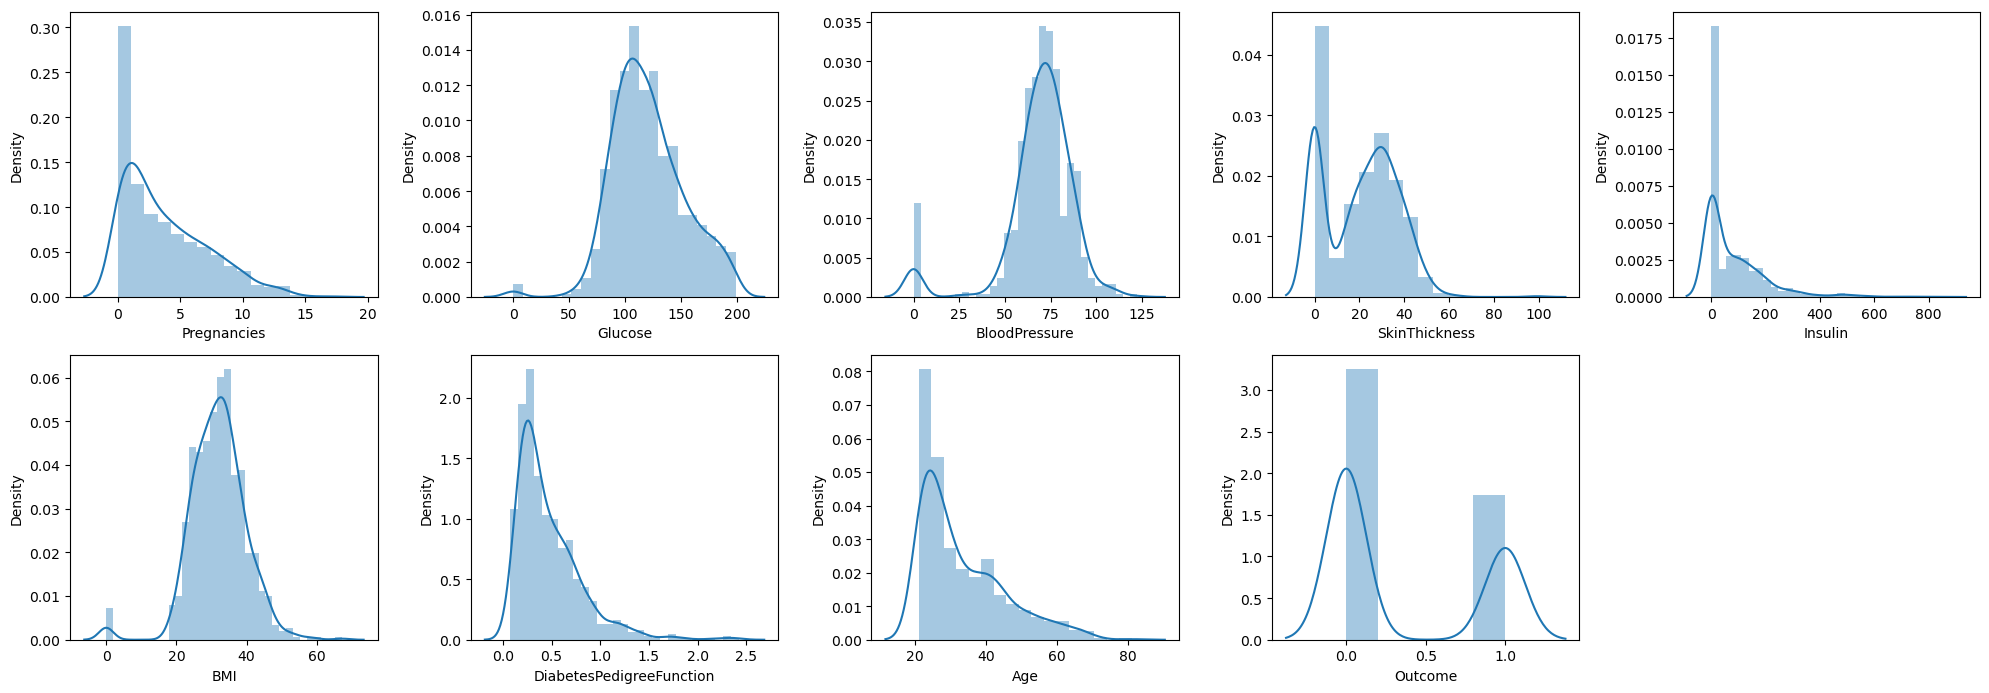

In [6]:
plt.figure(figsize = (20,10))
plot_number = 1

for column in num_cols:
    if plot_number <= 14:
        ax = plt.subplot(3, 5, plot_number)
        sns.distplot(diadata[column])
        plt.xlabel(column)
        
    plot_number += 1

plt.tight_layout()
plt.show()

由上圖中可以發現，Glucose、BloodPressure、SkinThickness 及 BMI的數據資料大多都集中在右手邊，但多出0的資料在左手邊，顯然數值為0的資料是有問題的，需要刪去

In [7]:
#計算有問題的資料數量
print("Glucose為0:",diadata["Glucose"].loc[diadata["Glucose"] == 0].count())
print("BloodPressure為0:",diadata["BloodPressure"].loc[diadata["BloodPressure"] == 0].count())
print("SkinThickness為0:",diadata["SkinThickness"].loc[diadata["SkinThickness"] == 0].count())
print("BMI為0:",diadata["BMI"].loc[diadata["BMI"] == 0].count())


Glucose為0: 5
BloodPressure為0: 35
SkinThickness為0: 227
BMI為0: 11


和同學討論，認為總資料數扣除至少227筆資料過多，可能會影響模型，所以決定先將扣除為0的資料做離群值的清理後，取期望值，填補0的資料空缺

In [8]:
#提琴圖，用來觀察離群值
def violin(col):
    fig = px.violin(diadata, y=col, x="Outcome", color="Outcome", box=True, template = 'plotly_dark')
    return fig.show()

In [9]:
fill_col = ["Glucose", "BloodPressure", "SkinThickness", "BMI"]

In [10]:
#扣除有問題的資料後，觀察各資料的離群值
for col in fill_col:
    diadata[col] = diadata[col].replace(0, np.nan)
for column in num_cols:
    violin(column)

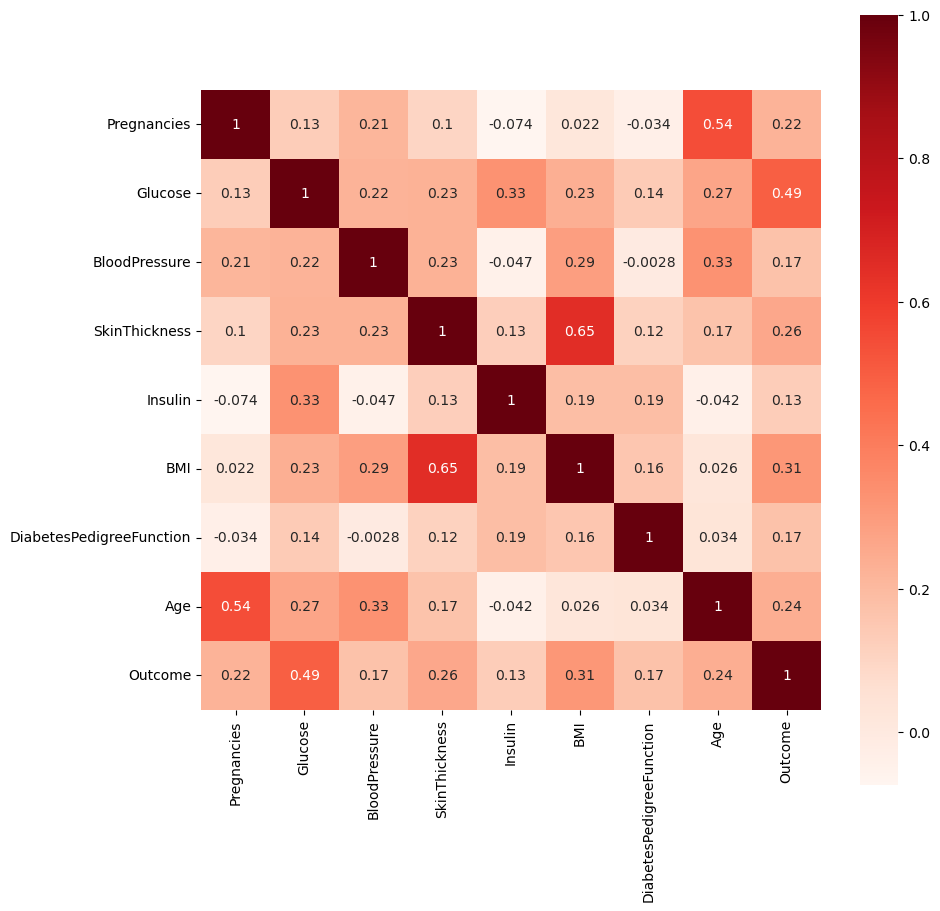

In [11]:
#查看各項資料與Outcome的相關程度
diadata_corr = diadata.corr() #計算相關係數
plt.subplots(figsize=(10, 10)) 
sns.heatmap(diadata_corr, annot=True, vmax=1, square=True, cmap="Reds")
#1.丟入的資料 2.是否輸出熱力圖數值大小 3.最大值顯示4.變成正方形5.要什麼顏色
plt.show()

##### 判別基準：(優先考慮1)
* 1.考慮現實狀況與生活經驗的數值，決定離群值是否刪去
* 2.各項資料與Outcome相關係數若低於0.3以下，則將離群值刪去\

可以看出，除Glucose、BMI以外，其餘類別資料的離群值都需考慮刪去，取Outcome 0 跟 1 當中的最小預估最大值和最大預估最小值作為預估最大最小值為基準\
1.Pregnancies: 正常經濟水準的國家，其生育次數應不會過高 ，因此 >11 者刪除\
2.BloodPressure: 正常血壓範圍為 120/80mmHg ~ 90/60mmHg ，因此 <48 者刪除\
3.SkinThickness: 經網路上查找資料，糖尿病會影響皮膚狀況，BMI與Outcome為中度相關，且SkinThickness與BMI為中度相關，因此不刪除離群值\
4.Insulin: 因為Glucose與Outcome為中度相關，且Insulin與Glucose亦為中度相關，因此不刪去離群值\
5.DiabetesPedigreeFunction: >1.022 者刪除\
6.Age:具經驗，年齡越大，得糖尿病可能性越高，所以不刪去離群值

In [12]:
#將離群值轉為nan
diadata['Pregnancies'].loc[diadata['Pregnancies'] > 11] = -1
diadata['BloodPressure'].loc[diadata['BloodPressure'].between(1,48)] = -1
diadata['DiabetesPedigreeFunction'].loc[diadata['DiabetesPedigreeFunction'] > 1.022] = -1

diadata = diadata.replace(-1, np.nan)
diadata.isnull().sum(axis=0)


C:\Users\X55V\AppData\Local\Temp\ipykernel_12724\762469385.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\X55V\AppData\Local\Temp\ipykernel_12724\762469385.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\X55V\AppData\Local\Temp\ipykernel_12724\762469385.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Pregnancies                  23
Glucose                       5
BloodPressure                51
SkinThickness               227
Insulin                       0
BMI                          11
DiabetesPedigreeFunction     48
Age                           0
Outcome                       0
dtype: int64

刪除的資料過多，改採期望值填補

In [13]:
#期望值函數
def E(data, col):
    Count = data.groupby([col], as_index=False)[col].agg({"cnt": "count"})
    datacnt = Count["cnt"].count()
    datasum = Count["cnt"].sum()
    E_value = 0
    for i in range(datacnt):
        E_value = E_value + Count[col][i] * (Count["cnt"][i] / datasum)

    return E_value

In [14]:
#將期望值填補入空缺資料
for col in num_cols:
    E_value = E(diadata, col)
    diadata[col] = diadata[col].replace(np.nan, E_value)

In [15]:
diadata.isnull().sum(axis=0)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [16]:
diadata.dtypes

Pregnancies                 float64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [17]:
#檢查是否有非整數值
Pre_val = diadata.Pregnancies.unique()
print(Pre_val)

[ 6.          1.          8.          0.          5.          3.
 10.          2.          4.          7.          9.         11.
  3.56375839]


In [18]:
#將非整數值調成整數值，用四捨五入方式
for i in range(0,len(diadata.Pregnancies)):
    diadata.Pregnancies[i] = round(diadata.Pregnancies[i])

C:\Users\X55V\AppData\Local\Temp\ipykernel_12724\890849559.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
#將資料型態轉回整數值
diadata.Pregnancies = diadata.Pregnancies.astype('int64')
diadata.Age = diadata.Age.astype('int64')

In [20]:
diadata.dtypes

Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [21]:
#分離預測目標
clear_diadata = diadata.drop(['Outcome'], axis=1)

label = diadata['Outcome']

In [22]:
print(clear_diadata.head(10))
print(clear_diadata.count())
clear_diadata.dtypes

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin        BMI  \
0            6    148.0      72.000000       35.00000        0  33.600000   
1            1     85.0      66.000000       29.00000        0  26.600000   
2            8    183.0      64.000000       29.15342        0  23.300000   
3            1     89.0      66.000000       23.00000       94  28.100000   
4            0    137.0      73.086471       35.00000      168  43.100000   
5            5    116.0      74.000000       29.15342        0  25.600000   
6            3     78.0      50.000000       32.00000       88  31.000000   
7           10    115.0      73.086471       29.15342        0  35.300000   
8            2    197.0      70.000000       45.00000      543  30.500000   
9            8    125.0      96.000000       29.15342        0  32.457464   

   DiabetesPedigreeFunction  Age  
0                  0.627000   50  
1                  0.351000   31  
2                  0.672000   32  
3           

Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

#### 模型開發

* 分割資料集

In [23]:
x_features = clear_diadata.iloc[:,:]
y_label = label
print(x_features)
print(y_label)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0      72.000000       35.00000        0  33.6   
1              1     85.0      66.000000       29.00000        0  26.6   
2              8    183.0      64.000000       29.15342        0  23.3   
3              1     89.0      66.000000       23.00000       94  28.1   
4              0    137.0      73.086471       35.00000      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10    101.0      76.000000       48.00000      180  32.9   
764            2    122.0      70.000000       27.00000        0  36.8   
765            5    121.0      72.000000       23.00000      112  26.2   
766            1    126.0      60.000000       29.15342        0  30.1   
767            1     93.0      70.000000       31.00000        0  30.4   

     DiabetesPedigreeFunction  Age  
0                    0.627000   50  
1                    0.351000   31  


In [24]:
from sklearn.model_selection import KFold

In [25]:
#切10份
kf = KFold(n_splits=10, shuffle=True, random_state=42)

* 選擇模型

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
model = LogisticRegression(max_iter=100000)

* K-Folk 交叉驗證

In [28]:
test_bias = []
test_variance = []
train_errors = []
test_errors = []

for train_index, test_index in kf.split(x_features):

    X_train, y_train = x_features.iloc[train_index], y_label[train_index]
    X_test, y_test = x_features.iloc[test_index], y_label[test_index]

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    bias = np.sum((y_test_pred - np.mean(y_test)) ** 2) / len(y_test_pred)
    variance = np.sum((y_test_pred - np.mean(y_test_pred)) ** 2) / len(y_test_pred)

    test_bias.append(bias)
    test_variance.append(variance)

    train_error = np.sum((y_train_pred - y_train) ** 2) / len(y_train_pred)
    test_error = np.sum((y_test_pred - y_test) ** 2) / len(y_test_pred)

    train_errors.append(train_error)
    test_errors.append(test_error)

print("Bias:",test_bias)
print("Variance:",test_variance)

print("平均訓練誤差：", sum(train_errors) / len(train_errors))
print("平均測試誤差：", sum(test_errors) / len(test_errors))


Bias: [0.23157362118401076, 0.20661157024793386, 0.20104570753921402, 0.18738404452690163, 0.21015348288075558, 0.22077922077922077, 0.2082981953111823, 0.16731320627424523, 0.2245498614958449, 0.20238919667590033]
Variance: [0.23140495867768593, 0.19834710743801648, 0.19834710743801648, 0.1858660819699781, 0.20408163265306117, 0.19227525721032215, 0.2040816326530612, 0.16461460617304768, 0.21606648199445985, 0.19390581717451527]
平均訓練誤差： 0.2258402834126632
平均測試誤差： 0.22792207792207791
